# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_save_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(lsm_test_name, trim_series=trim_series, mode="tiff")

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path

In [2]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

## Starting a Dask Client for parallelization

In [3]:
from dask.distributed import LocalCluster, Client

In [4]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [5]:
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:39061,Total threads: 1
Dashboard: http://127.0.0.1:43735/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:37143,


## Nuclear segmentation and tracking

In [7]:
import pipeline

In [8]:
%%time

nuclear_tracking = pipeline.Nuclear(
    data=nuclear_channel,
    global_metadata=export_global_metadata[1],
    frame_metadata=nuclear_channel_metadata,
    client=client,
)

nuclear_tracking.track_nuclei()

Frame 2: 1 trajectories present.
CPU times: user 18.7 s, sys: 13.8 s, total: 32.6 s
Wall time: 2min 45s


In [9]:
nuclear_labels = nuclear_tracking.reordered_labels
nuclear_labels_futures = nuclear_tracking.reordered_labels_futures

## Spot segmentation and fitting

It can be shown for an xy-symmetric Gaussian that
$$
\int_{\mathbb{R}^3} A e^{- \frac{x^2 + y^2}{2 \sigma_{xy}^2} - \frac{z^2}{2 \sigma_z^2}} \ dx \ dy \ dz = 2 \sqrt{2} A \pi^{3/2} \sigma_{xy}^2 \sigma_z
$$
where we have used notation consistent with that used in `spot_analysis.fitting`. We can therefore use simple algebraic manipulation of the fit parameters to estimate the spot intensities.

In [10]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [11]:
%%time

spot_tracking = pipeline.Spot(
    data=transcription_channel,
    global_metadata=export_global_metadata[0],
    frame_metadata=transcription_channel_metadata,
    nuclear_labels=nuclear_labels_futures,
    client=client,
    keep_bandpass=False,
)

spot_tracking.extract_spot_traces()

Frame 167: 28 trajectories present.
CPU times: user 24.1 s, sys: 23.3 s, total: 47.4 s
Wall time: 1min 56s


In [12]:
spot_labels = spot_tracking.reordered_spot_labels

## Compiling traces

In [13]:
from spot_analysis import compile_data

In [14]:
spot_dataframe = spot_tracking.spot_dataframe
mitosis_dataframe = nuclear_tracking.mitosis_dataframe

compiled_dataframe = compile_data.compile_traces(
    spot_dataframe,
    nuclear_tracking_dataframe=mitosis_dataframe,
    compile_columns_nuclear=["nuclear_cycle", "division_time"],
)

In [15]:
compiled_dataframe

,particle,frame,t_s,intensity_from_fit,nuclear_cycle,division_time
0,1,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[1429.706587936108, 1446.419835997688, 1463.32...","[25777.055196510464, 68682.37928585931, 121900...",14,1299.588400
1,2,"[96, 98, 99, 100, 101, 103, 104, 105, 106, 107...","[1666.094064650335, 1699.820489544834, 1716.34...","[10659.59808823916, 19381.33376941381, 23286.7...",14,1188.462547
2,4,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[1465.1640585134764, 1480.983051725455, 1497.8...","[23623.22809890094, 70628.06085800716, 174875....",14,1170.081971
3,5,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[1464.6515103157697, 1481.400321773263, 1497.8...","[53860.67924473973, 149196.948053475, 233496.4...",14,1186.977725
4,7,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[1463.8491499487357, 1480.4648159747064, 1497....","[32237.950733251593, 59901.236767649396, 13761...",14,1184.739172
...,...,...,...,...,...,...
200,413,"[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[1513.5767485937324, 1531.0052603218778, 1548....","[17971.703546736204, 20554.68967334697, 32703....",14,1205.090575
201,414,"[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[1530.0459133408049, 1547.624060058772, 1564.0...","[28778.581520187956, 30618.538319829222, 76680...",14,1220.222055
202,415,"[86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[1496.7922502266956, 1531.5205885269586, 1548....","[26757.920949519856, 44905.16254096105, 55614....",14,1316.723646
203,416,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[1464.2013744769736, 1480.7410193629564, 1498....","[19280.04641208358, 50283.09929887829, 77158.0...",14,1316.009522


## Visualizing traces

In [16]:
from utils import plottable

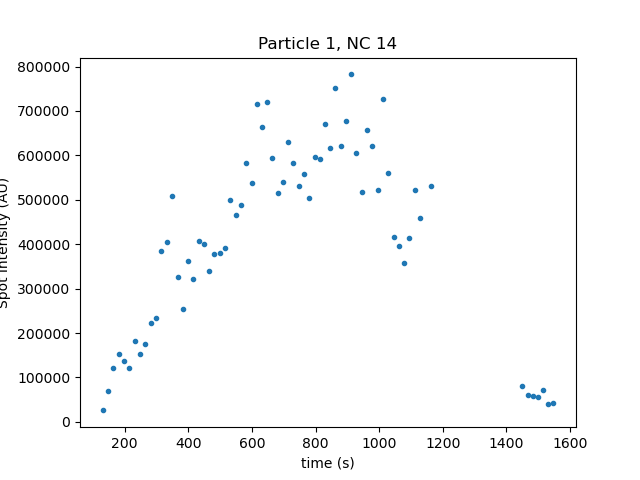

In [17]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

traces = plottable.generate_trace_plot_list(compiled_dataframe)

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")
    ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")
ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")

plt.show()

In [18]:
from tracking import detect_mitosis

In [20]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
viewer.add_labels(nuclear_labels)
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)
viewer.add_image(transcription_channel, name="Transcription Channel")
viewer.add_labels(spot_labels)
napari.run()